# Random Forest - AAPL Microstructure Prediction

**Objective:** Train Random Forest ensemble classifiers and compare against single Decision Tree and baseline models.

**Inputs:**

- Features with regimes from notebook 30 (`AAPL_features_with_regimes.parquet`)
- Baseline results from notebook 35
- Decision Tree results from notebook 40
- **Time period:** December 9-13, 2024 (5 trading days)

**Models:**

- Random Forest with varying numbers of estimators
- Hyperparameter tuning: n_estimators, max_depth, min_samples_split, max_features
- Out-of-bag (OOB) error estimation

**Outputs:**

- Tuned Random Forest models
- Performance comparison vs. Decision Tree and baseline
- Feature importance analysis
- OOB score analysis
- Ensemble size vs. performance analysis

**Target Variable:** Next-period mid-price direction (up=1, down=0)


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import time
import warnings

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# Visualization
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

# Import project config
import sys

sys.path.append("..")
from src.config import PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, TABLES_DIR

# Create output directories
rf_dir = FIGURES_DIR / "random_forest"
rf_dir.mkdir(parents=True, exist_ok=True)

# Set random seed
np.random.seed(42)

print(" Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Figures directory: {rf_dir}")

 Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed
  Models directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models
  Figures directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/random_forest


In [2]:
# Configuration
TICKER = "AAPL"
START_DATE = "2024-12-09"  # Start date for multi-day data
END_DATE = "2024-12-13"  # End date for multi-day data
DATE_RANGE = f"{START_DATE}_to_{END_DATE}"  # File naming convention

print(f"Ticker: {TICKER}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Working with 5 days of data for random forest training")

Ticker: AAPL
Date range: 2024-12-09 to 2024-12-13
Working with 5 days of data for random forest training


## 2. Load Data and Previous Results


In [3]:
# Load features with regimes from notebook 30
print("Loading features with regimes...")
features_with_regimes = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_with_regimes.parquet"
).reset_index(drop=True)

print(f" Features with regimes: {features_with_regimes.shape}")

# Load baseline results for comparison
with open(MODELS_DIR / "baseline_results.json", "r") as f:
    baseline_results = json.load(f)

# Load decision tree results for comparison
with open(MODELS_DIR / "decision_tree_results.json", "r") as f:
    dt_results = json.load(f)

print("\n Loaded previous results")
print(f"\nBaseline (Logistic Regression L2):")
print(f"  Test Accuracy: {baseline_results['lr_l2']['test_accuracy']:.4f}")
print(f"  Test F1:       {baseline_results['lr_l2']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {baseline_results['lr_l2']['test_roc_auc']:.4f}")

print(f"\nDecision Tree (Tuned):")
print(f"  Test Accuracy: {dt_results['dt_tuned']['test_accuracy']:.4f}")
print(f"  Test F1:       {dt_results['dt_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {dt_results['dt_tuned']['test_roc_auc']:.4f}")

Loading features with regimes...
 Features with regimes: (1365, 94)

 Loaded previous results

Baseline (Logistic Regression L2):
  Test Accuracy: 0.6813
  Test F1:       0.6667
  Test ROC-AUC:  0.7337

Decision Tree (Tuned):
  Test Accuracy: 0.6374
  Test F1:       0.6689
  Test ROC-AUC:  0.6313


## 3. Create Target Variable and Features


In [4]:
# Find price column
price_candidates = ["agg_mid_price", "agg_close", "mid_price", "close"]
price_col = next(
    (col for col in price_candidates if col in features_with_regimes.columns), None
)

if price_col is None:
    raise ValueError(
        f"No price column found. Available columns: {features_with_regimes.columns.tolist()[:20]}"
    )

print(f"Using price column: {price_col}")

# Create target: 1 if next price > current price, 0 otherwise
features_with_regimes["price_next"] = features_with_regimes[price_col].shift(-1)
features_with_regimes["target"] = (
    features_with_regimes["price_next"] > features_with_regimes[price_col]
).astype(int)

# Remove last row (no future price)
features_with_regimes = features_with_regimes[:-1].copy()

print(f"\n Target variable created")
print(f"  Shape: {features_with_regimes.shape}")

Using price column: agg_mid_price

 Target variable created
  Shape: (1364, 96)


## 4. Feature Selection and Cleaning


In [5]:
# Columns to exclude from features
exclude_cols = [
    "timestamp",
    "target",
    "price_next",
    "regime_hmm",
    "regime_hawkes",
    "regime_hawkes_binary",
    "hmm_state",
    "time_hour",
    "time_minute",
    "time_minutes_since_open",
    "time_session",
    "hour",
    "minute",
    "time_of_day",
]

# Get feature columns
feature_cols = [col for col in features_with_regimes.columns if col not in exclude_cols]

# Select only numeric features
X = features_with_regimes[feature_cols].select_dtypes(include=[np.number])
feature_cols = X.columns.tolist()

# Get target
y = features_with_regimes["target"].values

# Handle missing and infinite values
X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f" Feature matrix: {X.shape}")
print(f" Target vector: {y.shape}")

 Feature matrix: (1364, 81)
 Target vector: (1364,)


## 5. Train-Test Split (Time-Series)


In [6]:
# Time-series split (no shuffling)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Train set: {X_train.shape[0]:,} samples ({100*len(X_train)/len(X):.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({100*len(X_test)/len(X):.1f}%)")

Train set: 1,091 samples (80.0%)
Test set: 273 samples (20.0%)


## 6. Baseline Random Forest

Train with default parameters and OOB score


In [7]:
# Train baseline random forest
print("Training baseline Random Forest (100 trees, default parameters)...")

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)

start_time = time.time()
rf_baseline.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_train_pred_base = rf_baseline.predict(X_train)
y_test_pred_base = rf_baseline.predict(X_test)
y_test_proba_base = rf_baseline.predict_proba(X_test)[:, 1]

# Metrics
print("\n" + "=" * 80)
print("BASELINE RANDOM FOREST (100 trees, default parameters)")
print("=" * 80)

print(f"\nTraining time: {train_time:.2f} seconds")
print(f"OOB Score: {rf_baseline.oob_score_:.4f}")

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_base):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_base):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_base):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_base):.4f}")

print("\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_base):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_base):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_test_pred_base):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba_base):.4f}")

# Compare to single tree
print("\nIMPROVEMENT OVER SINGLE DECISION TREE:")
dt_test_acc = dt_results["dt_tuned"]["test_accuracy"]
dt_test_f1 = dt_results["dt_tuned"]["test_f1"]
rf_test_acc = accuracy_score(y_test, y_test_pred_base)
rf_test_f1 = f1_score(y_test, y_test_pred_base)

print(
    f"  Accuracy:  {rf_test_acc - dt_test_acc:+.4f} ({100*(rf_test_acc - dt_test_acc)/dt_test_acc:+.1f}%)"
)
print(
    f"  F1-score:  {rf_test_f1 - dt_test_f1:+.4f} ({100*(rf_test_f1 - dt_test_f1)/dt_test_f1:+.1f}%)"
)

Training baseline Random Forest (100 trees, default parameters)...

BASELINE RANDOM FOREST (100 trees, default parameters)

Training time: 0.20 seconds
OOB Score: 0.6682

TRAIN SET:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000

TEST SET:
  Accuracy:  0.6374
  Precision: 0.7059
  Recall:    0.5106
  F1-score:  0.5926
  ROC-AUC:   0.7083

IMPROVEMENT OVER SINGLE DECISION TREE:
  Accuracy:  +0.0000 (+0.0%)
  F1-score:  -0.0763 (-11.4%)


## 7. Ensemble Size Analysis

Test different numbers of trees to find optimal ensemble size


In [8]:
# Test different ensemble sizes
print("Testing different ensemble sizes...")

n_estimators_range = [10, 25, 50, 100, 150, 200, 300, 500]
ensemble_results = []

for n_est in n_estimators_range:
    print(f"  Training with {n_est} trees...", end=" ")

    rf = RandomForestClassifier(
        n_estimators=n_est,
        oob_score=True,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1,
    )

    start_time = time.time()
    rf.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    y_test_proba = rf.predict_proba(X_test)[:, 1]

    # Inference time (average per sample)
    start_time = time.time()
    _ = rf.predict(X_test.iloc[:100])  # Sample 100 for timing
    inference_time = (time.time() - start_time) / 100 * 1000  # ms per sample

    ensemble_results.append(
        {
            "n_estimators": n_est,
            "train_time": train_time,
            "inference_time_ms": inference_time,
            "oob_score": rf.oob_score_,
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_test_pred),
            "test_f1": f1_score(y_test, y_test_pred),
            "test_roc_auc": roc_auc_score(y_test, y_test_proba),
            "overfit_gap": accuracy_score(y_train, y_train_pred)
            - accuracy_score(y_test, y_test_pred),
        }
    )

    print(f"done ({train_time:.1f}s)")

ensemble_df = pd.DataFrame(ensemble_results)

print("\n" + "=" * 80)
print("ENSEMBLE SIZE ANALYSIS")
print("=" * 80)
print(ensemble_df.to_string(index=False))

# Find optimal size
optimal_idx = ensemble_df["test_f1"].idxmax()
optimal_n_est = ensemble_df.loc[optimal_idx, "n_estimators"]
print(f"\n Optimal n_estimators: {int(optimal_n_est)}")
print(f"  Test F1-score: {ensemble_df.loc[optimal_idx, 'test_f1']:.4f}")
print(f"  Training time: {ensemble_df.loc[optimal_idx, 'train_time']:.2f}s")
print(
    f"  Inference time: {ensemble_df.loc[optimal_idx, 'inference_time_ms']:.2f}ms per sample"
)

Testing different ensemble sizes...
  Training with 10 trees... done (0.0s)
  Training with 25 trees... done (0.1s)
  Training with 50 trees... done (0.1s)
  Training with 100 trees... done (0.2s)
  Training with 150 trees... done (0.3s)
  Training with 200 trees... done (0.4s)
  Training with 300 trees... done (0.6s)
  Training with 500 trees... done (1.1s)

ENSEMBLE SIZE ANALYSIS
 n_estimators  train_time  inference_time_ms  oob_score  train_acc  test_acc  test_f1  test_roc_auc  overfit_gap
           10    0.035981           0.146170   0.615949   0.983501  0.560440 0.487179      0.630561     0.423062
           25    0.052764           0.150111   0.638863   0.999083  0.622711 0.605364      0.699280     0.376373
           50    0.099641           0.133691   0.653529   0.999083  0.622711 0.565401      0.713438     0.376373
          100    0.183849           0.145772   0.668194   1.000000  0.637363 0.592593      0.708280     0.362637
          150    0.262283           0.147920   0.6

## 8. Visualize Ensemble Size Analysis


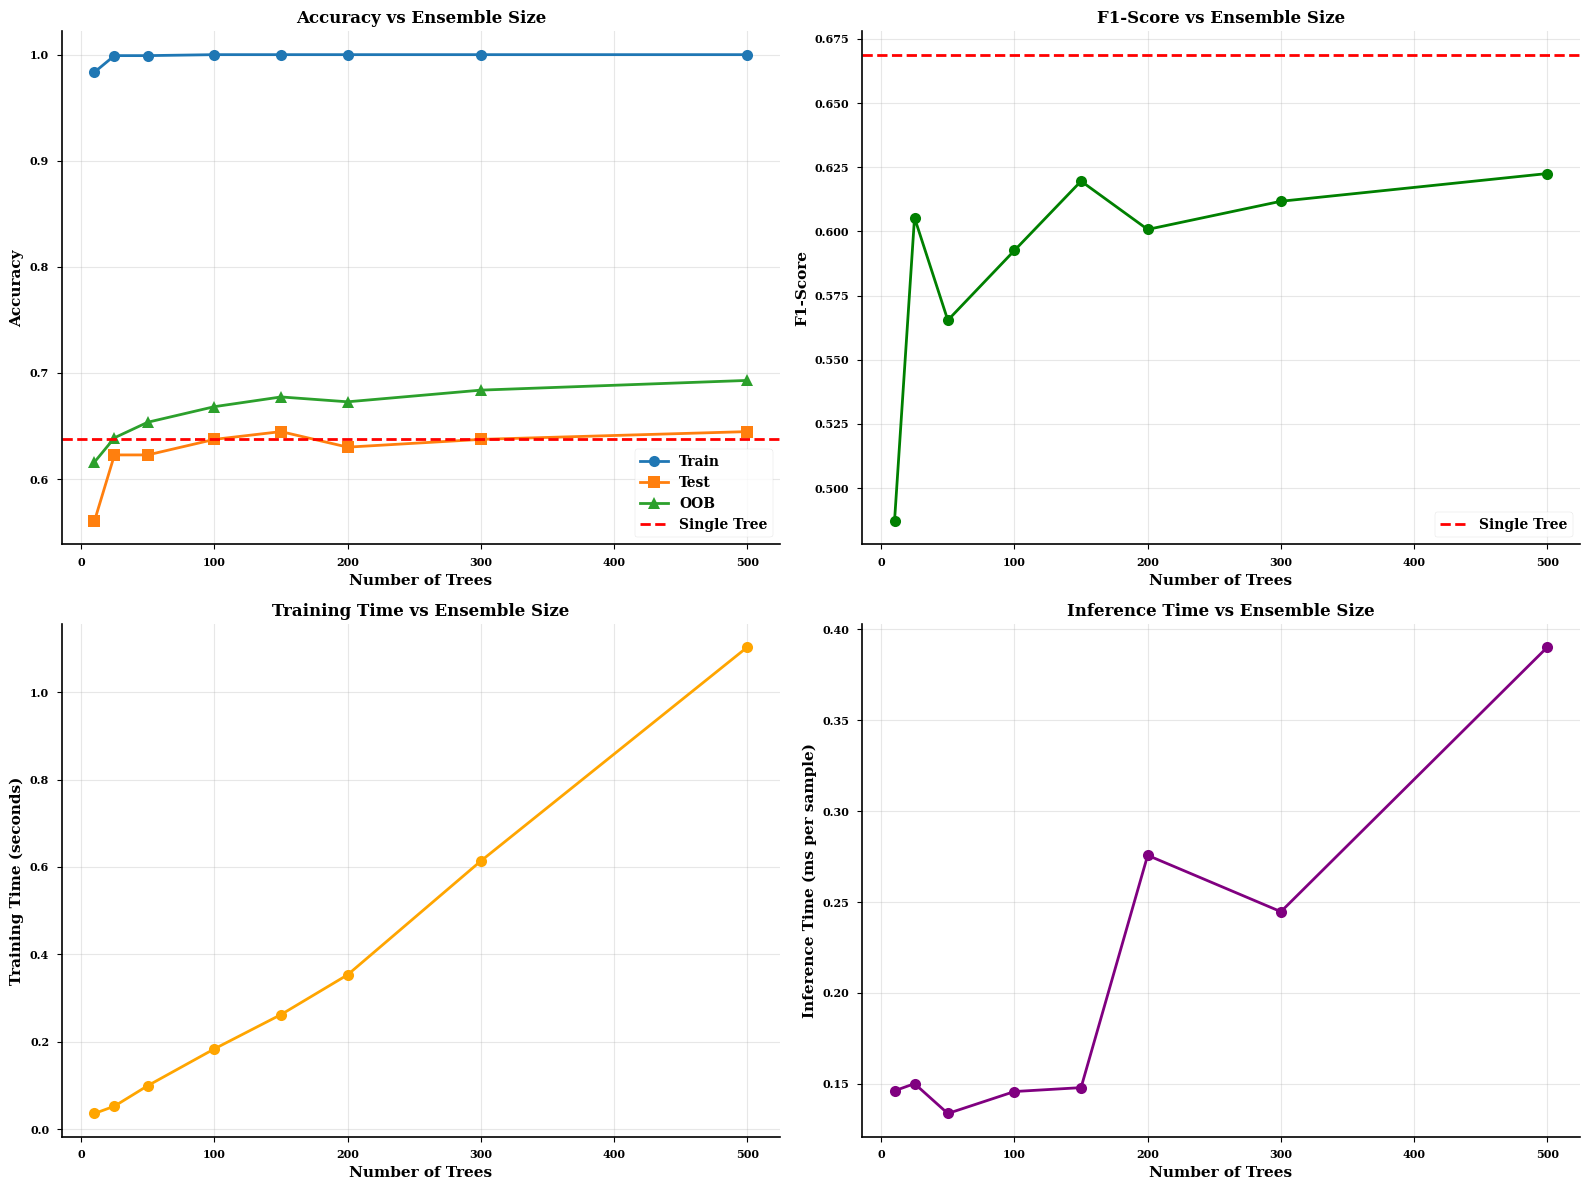


 Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/random_forest/ensemble_size_analysis.png


In [9]:
# Plot ensemble size analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy vs Ensemble Size
axes[0, 0].plot(
    ensemble_df["n_estimators"],
    ensemble_df["train_acc"],
    "o-",
    linewidth=2,
    markersize=8,
    label="Train",
)
axes[0, 0].plot(
    ensemble_df["n_estimators"],
    ensemble_df["test_acc"],
    "s-",
    linewidth=2,
    markersize=8,
    label="Test",
)
axes[0, 0].plot(
    ensemble_df["n_estimators"],
    ensemble_df["oob_score"],
    "^-",
    linewidth=2,
    markersize=8,
    label="OOB",
)
axes[0, 0].axhline(
    y=dt_results["dt_tuned"]["test_accuracy"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Single Tree",
)
axes[0, 0].set_xlabel("Number of Trees", fontsize=11)
axes[0, 0].set_ylabel("Accuracy", fontsize=11)
axes[0, 0].set_title("Accuracy vs Ensemble Size", fontsize=12, fontweight="bold")
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Plot 2: F1-score vs Ensemble Size
axes[0, 1].plot(
    ensemble_df["n_estimators"],
    ensemble_df["test_f1"],
    "o-",
    linewidth=2,
    markersize=8,
    color="green",
)
axes[0, 1].axhline(
    y=dt_results["dt_tuned"]["test_f1"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Single Tree",
)
axes[0, 1].set_xlabel("Number of Trees", fontsize=11)
axes[0, 1].set_ylabel("F1-Score", fontsize=11)
axes[0, 1].set_title("F1-Score vs Ensemble Size", fontsize=12, fontweight="bold")
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Training Time vs Ensemble Size
axes[1, 0].plot(
    ensemble_df["n_estimators"],
    ensemble_df["train_time"],
    "o-",
    linewidth=2,
    markersize=8,
    color="orange",
)
axes[1, 0].set_xlabel("Number of Trees", fontsize=11)
axes[1, 0].set_ylabel("Training Time (seconds)", fontsize=11)
axes[1, 0].set_title("Training Time vs Ensemble Size", fontsize=12, fontweight="bold")
axes[1, 0].grid(alpha=0.3)

# Plot 4: Inference Time vs Ensemble Size
axes[1, 1].plot(
    ensemble_df["n_estimators"],
    ensemble_df["inference_time_ms"],
    "o-",
    linewidth=2,
    markersize=8,
    color="purple",
)
axes[1, 1].set_xlabel("Number of Trees", fontsize=11)
axes[1, 1].set_ylabel("Inference Time (ms per sample)", fontsize=11)
axes[1, 1].set_title("Inference Time vs Ensemble Size", fontsize=12, fontweight="bold")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(rf_dir / "ensemble_size_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {rf_dir / 'ensemble_size_analysis.png'}")

## 9. Hyperparameter Tuning with Randomized Search

Use RandomizedSearchCV for efficient hyperparameter tuning


In [ ]:
# Define parameter distributions
param_distributions = {
    "n_estimators": [100, 150, 200, 300],
    "max_depth": [6, 8, 10, 12, 15],
    "min_samples_split": [20, 50, 100],
    "min_samples_leaf": [10, 20, 50],
    "max_features": ["sqrt", "log2", 0.3, 0.5],
}

print("Hyperparameter tuning with RandomizedSearchCV...")
print(f"Parameter distributions:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search (sample 50 combinations)
random_search = RandomizedSearchCV(
    RandomForestClassifier(
        random_state=42, class_weight="balanced", n_jobs=-1, oob_score=True
    ),
    param_distributions=param_distributions,
    n_iter=50,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

print(f"\nTesting {random_search.n_iter} parameter combinations...")
random_search.fit(X_train, y_train)

print("\n" + "=" * 80)
print("RANDOMIZED SEARCH RESULTS")
print("=" * 80)
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation F1-score: {random_search.best_score_:.4f}")

Hyperparameter tuning with RandomizedSearchCV...
Parameter distributions:
  n_estimators: [100, 150, 200, 300]
  max_depth: [6, 8, 10, 12, 15]
  min_samples_split: [20, 50, 100]
  min_samples_leaf: [10, 20, 50]
  max_features: ['sqrt', 'log2', 0.3, 0.5]

Testing 50 parameter combinations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


## 10. Train Final Tuned Model


In [ ]:
# Get best model from randomized search
rf_tuned = random_search.best_estimator_

# Predictions
y_train_pred_tuned = rf_tuned.predict(X_train)
y_test_pred_tuned = rf_tuned.predict(X_test)
y_test_proba_tuned = rf_tuned.predict_proba(X_test)[:, 1]

# Metrics
print("=" * 80)
print("TUNED RANDOM FOREST PERFORMANCE")
print("=" * 80)

print(f"\nModel configuration:")
print(f"  Number of trees: {rf_tuned.n_estimators}")
print(f"  Max depth: {rf_tuned.max_depth}")
print(f"  Min samples split: {rf_tuned.min_samples_split}")
print(f"  Min samples leaf: {rf_tuned.min_samples_leaf}")
print(f"  Max features: {rf_tuned.max_features}")
print(f"  OOB Score: {rf_tuned.oob_score_:.4f}")

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_tuned):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_tuned):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_tuned):.4f}")

print("\nTEST SET:")
test_acc_tuned = accuracy_score(y_test, y_test_pred_tuned)
test_f1_tuned = f1_score(y_test, y_test_pred_tuned)
test_auc_tuned = roc_auc_score(y_test, y_test_proba_tuned)

print(f"  Accuracy:  {test_acc_tuned:.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_tuned):.4f}")
print(f"  F1-score:  {test_f1_tuned:.4f}")
print(f"  ROC-AUC:   {test_auc_tuned:.4f}")

# Compare to baseline and decision tree
print("\nIMPROVEMENT OVER BASELINE (Logistic Regression L2):")
acc_improvement_base = test_acc_tuned - baseline_results["lr_l2"]["test_accuracy"]
f1_improvement_base = test_f1_tuned - baseline_results["lr_l2"]["test_f1"]
auc_improvement_base = test_auc_tuned - baseline_results["lr_l2"]["test_roc_auc"]

print(
    f"  Accuracy:  {acc_improvement_base:+.4f} ({100*acc_improvement_base/baseline_results['lr_l2']['test_accuracy']:+.1f}%)"
)
print(
    f"  F1-score:  {f1_improvement_base:+.4f} ({100*f1_improvement_base/baseline_results['lr_l2']['test_f1']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {auc_improvement_base:+.4f} ({100*auc_improvement_base/baseline_results['lr_l2']['test_roc_auc']:+.1f}%)"
)

print("\nIMPROVEMENT OVER DECISION TREE (Tuned):")
acc_improvement_dt = test_acc_tuned - dt_results["dt_tuned"]["test_accuracy"]
f1_improvement_dt = test_f1_tuned - dt_results["dt_tuned"]["test_f1"]
auc_improvement_dt = test_auc_tuned - dt_results["dt_tuned"]["test_roc_auc"]

print(
    f"  Accuracy:  {acc_improvement_dt:+.4f} ({100*acc_improvement_dt/dt_results['dt_tuned']['test_accuracy']:+.1f}%)"
)
print(
    f"  F1-score:  {f1_improvement_dt:+.4f} ({100*f1_improvement_dt/dt_results['dt_tuned']['test_f1']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {auc_improvement_dt:+.4f} ({100*auc_improvement_dt/dt_results['dt_tuned']['test_roc_auc']:+.1f}%)"
)

TUNED RANDOM FOREST PERFORMANCE

Model configuration:
  Number of trees: 300
  Max depth: 10
  Min samples split: 20
  Min samples leaf: 20
  Max features: 0.3
  OOB Score: 0.7049

TRAIN SET:
  Accuracy:  0.7910
  Precision: 0.7893
  Recall:    0.7520
  F1-score:  0.7702

TEST SET:
  Accuracy:  0.6300
  Precision: 0.6471
  Recall:    0.6241
  F1-score:  0.6354
  ROC-AUC:   0.6945

IMPROVEMENT OVER BASELINE (Logistic Regression L2):
  Accuracy:  -0.0513 (-7.5%)
  F1-score:  -0.0313 (-4.7%)
  ROC-AUC:   -0.0392 (-5.3%)

IMPROVEMENT OVER DECISION TREE (Tuned):
  Accuracy:  -0.0073 (-1.1%)
  F1-score:  -0.0335 (-5.0%)
  ROC-AUC:   +0.0632 (+10.0%)


## 11. Feature Importance Analysis


In [ ]:
# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf_tuned.feature_importances_}
).sort_values("importance", ascending=False)

# Filter to non-zero importance
feature_importance_nonzero = feature_importance[feature_importance["importance"] > 0]

print("=" * 80)
print("FEATURE IMPORTANCE (TOP 20)")
print("=" * 80)
print(feature_importance.head(20).to_string(index=False))

print(f"\nFeatures used: {len(feature_importance_nonzero)}/{len(feature_cols)}")
print(
    f"Top 10 features account for {100*feature_importance.head(10)['importance'].sum():.1f}% of total importance"
)
print(
    f"Top 20 features account for {100*feature_importance.head(20)['importance'].sum():.1f}% of total importance"
)

FEATURE IMPORTANCE (TOP 20)
                       feature  importance
impact_permanent_impact_5_mean    0.299186
            agg_vwap_deviation    0.088524
         agg_intrabar_momentum    0.071932
        trade_volume_imbalance    0.023913
  impact_impact_per_share_mean    0.017116
                    agg_trades    0.014698
     cluster_inter_arrival_std    0.014321
       impact_temp_impact_mean    0.014117
 trade_size_weighted_direction    0.013586
                    agg_volume    0.012440
         trade_trade_direction    0.012203
               adv_return_skew    0.012067
          adv_variance_ratio_5    0.010537
               branching_ratio    0.010465
                adv_vol_regime    0.009865
                    trade_vpin    0.009629
              trade_size_ma_10    0.009468
          agg_spread_30min_std    0.009436
               regime_duration    0.009356
               adv_return_kurt    0.009197

Features used: 80/81
Top 10 features account for 57.0% of total impo

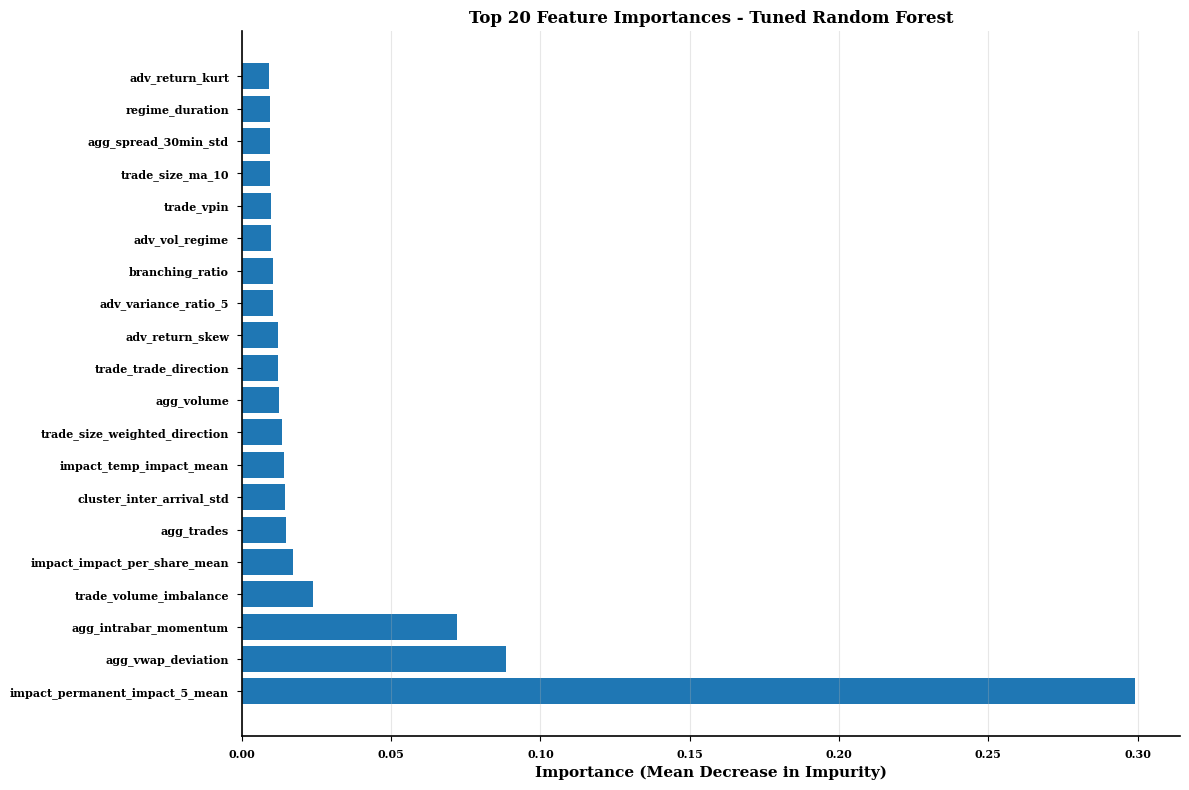


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/random_forest/feature_importance.png


In [ ]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features["importance"].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features["feature"].values)
ax.set_xlabel("Importance (Mean Decrease in Impurity)", fontsize=11)
ax.set_title(
    "Top 20 Feature Importances - Tuned Random Forest", fontsize=12, fontweight="bold"
)
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig(rf_dir / "feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {rf_dir / 'feature_importance.png'}")

## 12. Confusion Matrix and ROC Curve


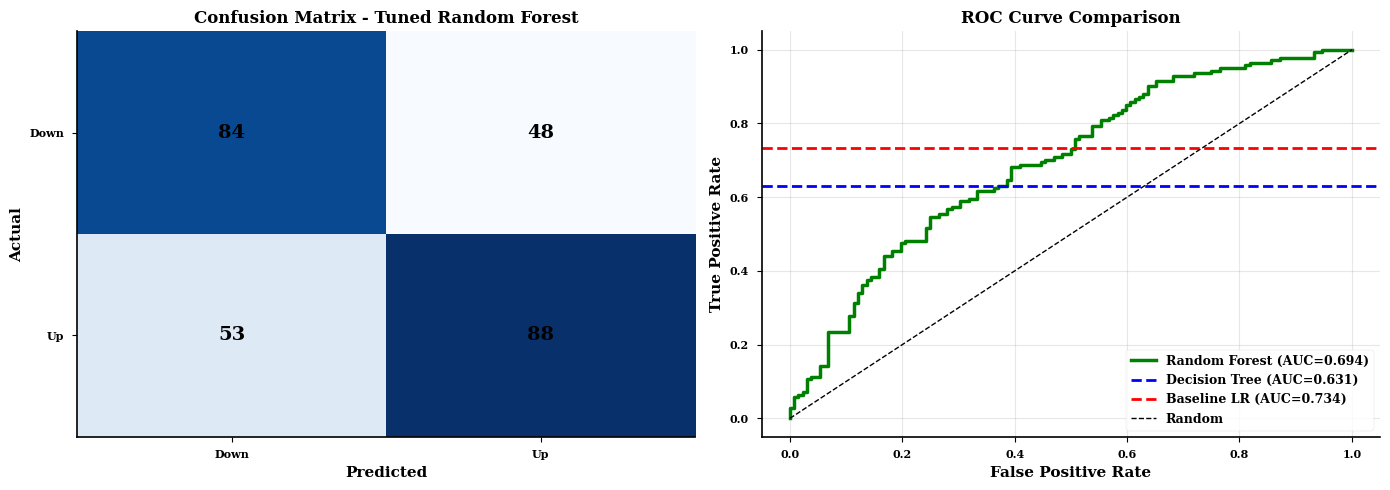


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/random_forest/performance.png


In [ ]:
# Create performance visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tuned)
im = axes[0].imshow(cm, cmap="Blues", aspect="auto")
axes[0].set_title(
    "Confusion Matrix - Tuned Random Forest", fontsize=12, fontweight="bold"
)
axes[0].set_xlabel("Predicted", fontsize=11)
axes[0].set_ylabel("Actual", fontsize=11)
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(["Down", "Up"])
axes[0].set_yticklabels(["Down", "Up"])

# Annotate cells
for row in range(2):
    for col in range(2):
        axes[0].text(
            col,
            row,
            str(cm[row, col]),
            ha="center",
            va="center",
            fontsize=14,
            fontweight="bold",
        )

# ROC curve - compare all models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_tuned)
axes[1].plot(
    fpr_rf,
    tpr_rf,
    linewidth=2.5,
    label=f"Random Forest (AUC={test_auc_tuned:.3f})",
    color="green",
)
axes[1].axhline(
    y=dt_results["dt_tuned"]["test_roc_auc"],
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Decision Tree (AUC={dt_results['dt_tuned']['test_roc_auc']:.3f})",
)
axes[1].axhline(
    y=baseline_results["lr_l2"]["test_roc_auc"],
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Baseline LR (AUC={baseline_results['lr_l2']['test_roc_auc']:.3f})",
)
axes[1].plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
axes[1].set_xlabel("False Positive Rate", fontsize=11)
axes[1].set_ylabel("True Positive Rate", fontsize=11)
axes[1].set_title("ROC Curve Comparison", fontsize=12, fontweight="bold")
axes[1].legend(loc="lower right", fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(rf_dir / "performance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {rf_dir / 'performance.png'}")

## 13. Model Comparison Visualization



MODEL COMPARISON
            Model  Accuracy  F1-Score  ROC-AUC
Logistic Reg (L2)  0.681319  0.666667 0.733720
    Decision Tree  0.637363  0.668896 0.631259
    Random Forest  0.630037  0.635379 0.694498


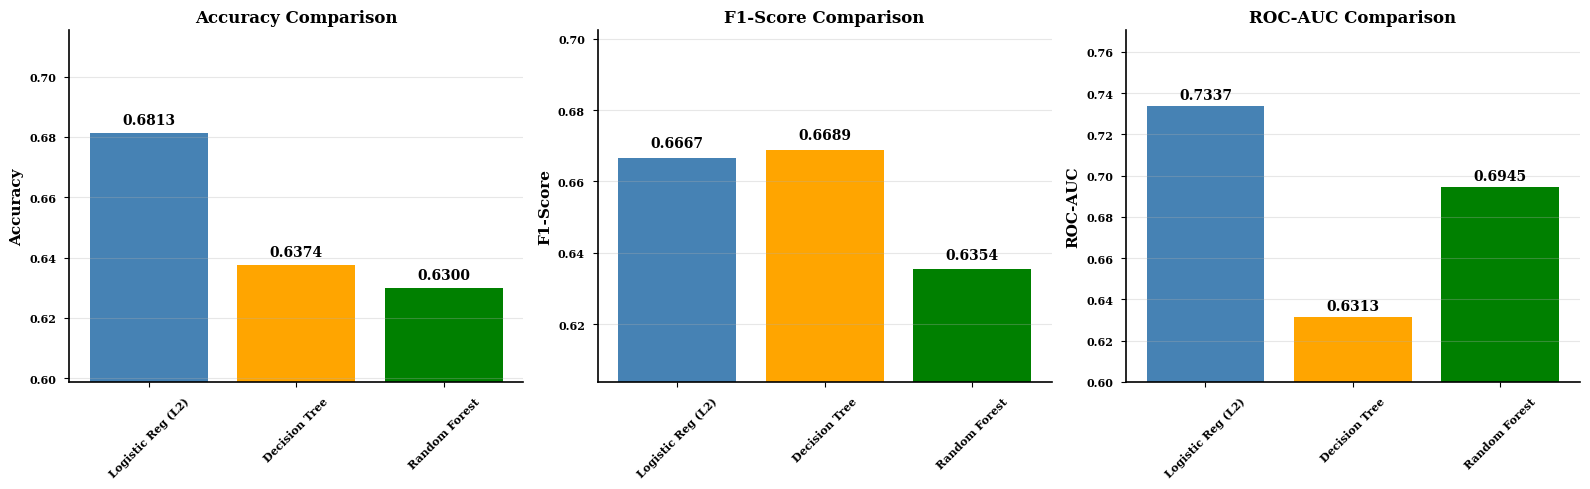


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/random_forest/model_comparison.png


In [ ]:
# Create comprehensive comparison
comparison_data = {
    "Model": ["Logistic Reg (L2)", "Decision Tree", "Random Forest"],
    "Accuracy": [
        baseline_results["lr_l2"]["test_accuracy"],
        dt_results["dt_tuned"]["test_accuracy"],
        test_acc_tuned,
    ],
    "F1-Score": [
        baseline_results["lr_l2"]["test_f1"],
        dt_results["dt_tuned"]["test_f1"],
        test_f1_tuned,
    ],
    "ROC-AUC": [
        baseline_results["lr_l2"]["test_roc_auc"],
        dt_results["dt_tuned"]["test_roc_auc"],
        test_auc_tuned,
    ],
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ["Accuracy", "F1-Score", "ROC-AUC"]
colors = ["steelblue", "orange", "green"]

for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df["Model"], comparison_df[metric], color=colors)
    axes[i].set_ylabel(metric, fontsize=11)
    axes[i].set_title(f"{metric} Comparison", fontsize=12, fontweight="bold")
    axes[i].set_ylim(
        [min(comparison_df[metric]) * 0.95, max(comparison_df[metric]) * 1.05]
    )
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(axis="y", alpha=0.3)

    # Annotate bars
    for j, v in enumerate(comparison_df[metric]):
        axes[i].text(
            j,
            v + 0.002,
            f"{v:.4f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

plt.tight_layout()
plt.savefig(rf_dir / "model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {rf_dir / 'model_comparison.png'}")

## 14. Save Models and Results


In [ ]:
# Save models
with open(MODELS_DIR / "random_forest_tuned.pkl", "wb") as f:
    pickle.dump(rf_tuned, f)
with open(MODELS_DIR / "random_forest_baseline.pkl", "wb") as f:
    pickle.dump(rf_baseline, f)

print(" Models saved:")
print(f"  {MODELS_DIR / 'random_forest_tuned.pkl'}")
print(f"  {MODELS_DIR / 'random_forest_baseline.pkl'}")

✓ Models saved:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/random_forest_tuned.pkl
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/random_forest_baseline.pkl


In [ ]:
# Save results
results = {
    "ticker": TICKER,
    "start_date": START_DATE,
    "end_date": END_DATE,
    "date_range": DATE_RANGE,
    "rf_baseline": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_base)),
        "test_accuracy": float(accuracy_score(y_test, y_test_pred_base)),
        "test_precision": float(precision_score(y_test, y_test_pred_base)),
        "test_recall": float(recall_score(y_test, y_test_pred_base)),
        "test_f1": float(f1_score(y_test, y_test_pred_base)),
        "test_roc_auc": float(roc_auc_score(y_test, y_test_proba_base)),
        "oob_score": float(rf_baseline.oob_score_),
        "n_estimators": int(rf_baseline.n_estimators),
    },
    "rf_tuned": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_tuned)),
        "test_accuracy": float(test_acc_tuned),
        "test_precision": float(precision_score(y_test, y_test_pred_tuned)),
        "test_recall": float(recall_score(y_test, y_test_pred_tuned)),
        "test_f1": float(test_f1_tuned),
        "test_roc_auc": float(test_auc_tuned),
        "oob_score": float(rf_tuned.oob_score_),
        "best_params": random_search.best_params_,
        "cv_f1_score": float(random_search.best_score_),
    },
    "improvement_over_baseline": {
        "accuracy": float(acc_improvement_base),
        "f1": float(f1_improvement_base),
        "roc_auc": float(auc_improvement_base),
        "accuracy_pct": float(
            100 * acc_improvement_base / baseline_results["lr_l2"]["test_accuracy"]
        ),
        "f1_pct": float(
            100 * f1_improvement_base / baseline_results["lr_l2"]["test_f1"]
        ),
        "roc_auc_pct": float(
            100 * auc_improvement_base / baseline_results["lr_l2"]["test_roc_auc"]
        ),
    },
    "improvement_over_decision_tree": {
        "accuracy": float(acc_improvement_dt),
        "f1": float(f1_improvement_dt),
        "roc_auc": float(auc_improvement_dt),
        "accuracy_pct": float(
            100 * acc_improvement_dt / dt_results["dt_tuned"]["test_accuracy"]
        ),
        "f1_pct": float(100 * f1_improvement_dt / dt_results["dt_tuned"]["test_f1"]),
        "roc_auc_pct": float(
            100 * auc_improvement_dt / dt_results["dt_tuned"]["test_roc_auc"]
        ),
    },
    "ensemble_size_analysis": ensemble_df.to_dict("records"),
}

with open(MODELS_DIR / "random_forest_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n Results saved to {MODELS_DIR / 'random_forest_results.json'}")
print(f"\nResults summary:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Train samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")


✓ Results saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/random_forest_results.json

Results summary:
  Ticker: AAPL
  Date range: 2024-12-09 to 2024-12-13 (5 trading days)
  Train samples: 1,091
  Test samples: 273


In [ ]:
# Save feature importance and ensemble analysis
feature_importance.to_csv(TABLES_DIR / "rf_feature_importance.csv", index=False)
ensemble_df.to_csv(TABLES_DIR / "rf_ensemble_size_analysis.csv", index=False)
comparison_df.to_csv(TABLES_DIR / "model_comparison.csv", index=False)

print(" Tables saved:")
print(f"  {TABLES_DIR / 'rf_feature_importance.csv'}")
print(f"  {TABLES_DIR / 'rf_ensemble_size_analysis.csv'}")
print(f"  {TABLES_DIR / 'model_comparison.csv'}")

✓ Tables saved:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/rf_feature_importance.csv
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/rf_ensemble_size_analysis.csv
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/model_comparison.csv


## 15. Summary


In [ ]:
print("=" * 80)
print(f"RANDOM FOREST ANALYSIS SUMMARY - {TICKER} ({START_DATE} to {END_DATE})")
print("=" * 80)

print(f"\nData Coverage:")
print(f"  Date range: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Train samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\nBaseline Random Forest (100 trees):")
print(f"  Test Accuracy: {results['rf_baseline']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['rf_baseline']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['rf_baseline']['test_roc_auc']:.4f}")
print(f"  OOB Score:     {results['rf_baseline']['oob_score']:.4f}")

print(f"\nTuned Random Forest:")
print(f"  Test Accuracy: {results['rf_tuned']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['rf_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['rf_tuned']['test_roc_auc']:.4f}")
print(f"  OOB Score:     {results['rf_tuned']['oob_score']:.4f}")

print(f"\nBest Hyperparameters:")
for param, value in results["rf_tuned"]["best_params"].items():
    print(f"  {param}: {value}")

print(f"\nImprovement over Baseline (Logistic Regression L2):")
print(
    f"  Accuracy:  {results['improvement_over_baseline']['accuracy']:+.4f} ({results['improvement_over_baseline']['accuracy_pct']:+.1f}%)"
)
print(
    f"  F1-score:  {results['improvement_over_baseline']['f1']:+.4f} ({results['improvement_over_baseline']['f1_pct']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {results['improvement_over_baseline']['roc_auc']:+.4f} ({results['improvement_over_baseline']['roc_auc_pct']:+.1f}%)"
)

print(f"\nImprovement over Decision Tree:")
print(
    f"  Accuracy:  {results['improvement_over_decision_tree']['accuracy']:+.4f} ({results['improvement_over_decision_tree']['accuracy_pct']:+.1f}%)"
)
print(
    f"  F1-score:  {results['improvement_over_decision_tree']['f1']:+.4f} ({results['improvement_over_decision_tree']['f1_pct']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {results['improvement_over_decision_tree']['roc_auc']:+.4f} ({results['improvement_over_decision_tree']['roc_auc_pct']:+.1f}%)"
)

print(f"\nKey Insights:")
print(
    f"  - Random Forest {'outperforms' if test_acc_tuned > dt_results['dt_tuned']['test_accuracy'] else 'underperforms'} single Decision Tree"
)
print(
    f"  - Ensemble of {results['rf_tuned']['best_params']['n_estimators']} trees provides optimal performance"
)
print(
    f"  - OOB score ({results['rf_tuned']['oob_score']:.4f}) closely matches test accuracy ({results['rf_tuned']['test_accuracy']:.4f})"
)
print(
    f"  - Top 10 features account for {100*feature_importance.head(10)['importance'].sum():.1f}% of importance"
)
print(f"  - Analysis covers 5 trading days ({START_DATE} to {END_DATE})")

print(f"\nNext Steps:")
print(f"  - Notebook 50: Gradient Boosting (sequential boosting)")
print(f"  - Compare boosting vs. bagging approaches")
print(f"  - Analyze which method works best for microstructure prediction")

print("\n" + "=" * 80)

RANDOM FOREST ANALYSIS SUMMARY - AAPL (2024-12-09 to 2024-12-13)

Data Coverage:
  Date range: 2024-12-09 to 2024-12-13 (5 trading days)
  Train samples: 1,091
  Test samples: 273
  Features: 81

Baseline Random Forest (100 trees):
  Test Accuracy: 0.6374
  Test F1-score: 0.5926
  Test ROC-AUC:  0.7083
  OOB Score:     0.6682

Tuned Random Forest:
  Test Accuracy: 0.6300
  Test F1-score: 0.6354
  Test ROC-AUC:  0.6945
  OOB Score:     0.7049

Best Hyperparameters:
  n_estimators: 300
  min_samples_split: 20
  min_samples_leaf: 20
  max_features: 0.3
  max_depth: 10

Improvement over Baseline (Logistic Regression L2):
  Accuracy:  -0.0513 (-7.5%)
  F1-score:  -0.0313 (-4.7%)
  ROC-AUC:   -0.0392 (-5.3%)

Improvement over Decision Tree:
  Accuracy:  -0.0073 (-1.1%)
  F1-score:  -0.0335 (-5.0%)
  ROC-AUC:   +0.0632 (+10.0%)

Key Insights:
  - Random Forest underperforms single Decision Tree
  - Ensemble of 300 trees provides optimal performance
  - OOB score (0.7049) closely matches test 